# Source water dynamics during upwelling and downwelling

In [1]:
import xarray as xr
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def wm_day_divide(mydata):
    start = 2401
    length =int((np.max(mydata.init_t)-start+1)/24)

    bdy_loo = 0
    bdy_sou = 2
    bdy_off = 3
    bdy_nor = 4

    saltdiv = 32
    sdiv = 33.5

    fresh = [np.sum(mydata.final_transp[(mydata.final_section==bdy_sou) & (mydata.final_salt < saltdiv) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    cuc = [np.sum(mydata.final_transp[(mydata.final_section==bdy_sou) & (mydata.final_salt >= sdiv) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    south = [np.sum(mydata.final_transp[(mydata.final_section==bdy_sou) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv)  & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    north = [np.sum(mydata.final_transp[(mydata.final_section==bdy_nor) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    offshore_d = [np.sum(mydata.final_transp[(mydata.final_section==bdy_off) & (mydata.final_depth > 120) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    offshore_s = [np.sum(mydata.final_transp[(mydata.final_section==bdy_off) & (mydata.final_depth <=120) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
    
    loop = [np.sum(mydata.final_transp[(mydata.final_section==bdy_loo) & (abs(mydata.init_t-mydata.final_t) > 24) & (mydata.init_t >= start+(i*24)) & (mydata.init_t <= start+(i*24)+23)]).values/24 for i in range(length)]
 
    return fresh, cuc, south, north, offshore_d, offshore_s, loop

def transport_df(data, start, length, years):
    # Create a master DataFrame to hold all the transport data, sorted by year day
    # data = list of transport arrays (from wm_day_divide) 
    # start = list of dt.datetime start days (start of season, not start of ariane run)
    # length = list of interger season length

    transport_data = pd.DataFrame()

    # Loop through each year's data and add it to the master DataFrame
    for year, start, season_length, transport in zip(years, startday, length, data):
        # Generate dates for the season
        dates = [start + dt.timedelta(days=x) for x in range(season_length)]
        
        # Extract month, day, and yearday
        month = [date.month for date in dates]
        day = [date.day for date in dates]
        yearday = [date.timetuple().tm_yday for date in dates]
        
        # Create a temporary DataFrame
        temp_df = pd.DataFrame({
            'month': month,
            'day': day,
            'yearday': yearday,
            f'transport_{year}': transport  # Transport column named by year
        })
        
        # Merge with the master DataFrame on 'month', 'day', and 'yearday'
        if transport_data.empty:
            transport_data = temp_df
        else:
            transport_data = pd.merge(transport_data, temp_df, on=['month', 'day', 'yearday'], how='outer')

        # Sort by yearday for better organization
        transport_data = transport_data.sort_values(by=['yearday']).reset_index(drop=True)

    return transport_data

## Upwelling

In [4]:
df22 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20221015/ariane_positions_quantitative.nc')
df21 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20210922/ariane_positions_quantitative.nc')
df14 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20140903/ariane_positions_quantitative.nc')
df13 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20131024/ariane_positions_quantitative.nc')

In [6]:
fresh22, cuc22, south22, north22, offshore_d22, offshore_s22, loop22 = wm_day_divide(df22)
fresh21, cuc21, south21, north21, offshore_d21, offshore_s21, loop21 = wm_day_divide(df21)
fresh14, cuc14, south14, north14, offshore_d14, offshore_s14, loop14 = wm_day_divide(df14)
fresh13, cuc13, south13, north13, offshore_d13, offshore_s13, loop13 = wm_day_divide(df13)


In [7]:
startday = [dt.datetime(2013, 10, 24)-dt.timedelta(days=219), dt.datetime(2014, 9, 3)-dt.timedelta(days=161), 
            dt.datetime(2021, 9, 22)-dt.timedelta(days=189), dt.datetime(2022, 6, 15)-dt.timedelta(days=117)]  # Start dates
length = [219, 161, 189, 117]  # Number of days in the season for each year

In [8]:
fresh = transport_df([fresh13, fresh14, fresh21,fresh22], startday, length,[2013,2014,2021,2022])
south = transport_df([south13, south14, south21,south22], startday, length,[2013,2014,2021,2022])
north = transport_df([north13, north14, north21,north22], startday, length,[2013,2014,2021,2022])
cuc = transport_df([cuc13, cuc14, cuc21,cuc22], startday, length,[2013,2014,2021,2022])
offshore_d = transport_df([offshore_d13, offshore_d14, offshore_d21,offshore_d22], startday, length,[2013,2014,2021,2022])
offshore_s = transport_df([offshore_s13, offshore_s14, offshore_s21,offshore_s22], startday, length,[2013,2014,2021,2022])
loop = transport_df([loop13, loop14, loop21,loop22], startday, length,[2013,2014,2021,2022])

In [9]:
# Add a count column to track the number of transport columns with data
# doing this with loop flow bc there will always be loop flow
transport_columns = [col for col in loop.columns if col.startswith('transport_')]
loop['count'] = loop[transport_columns].notna().sum(axis=1)

In [ ]:
data = [loop.transport_2013,loop.transport_2014,loop.transport_2021,loop.transport_2022]
np.percentile(data, [25], method='midpoint',axis=0)[0]

nan

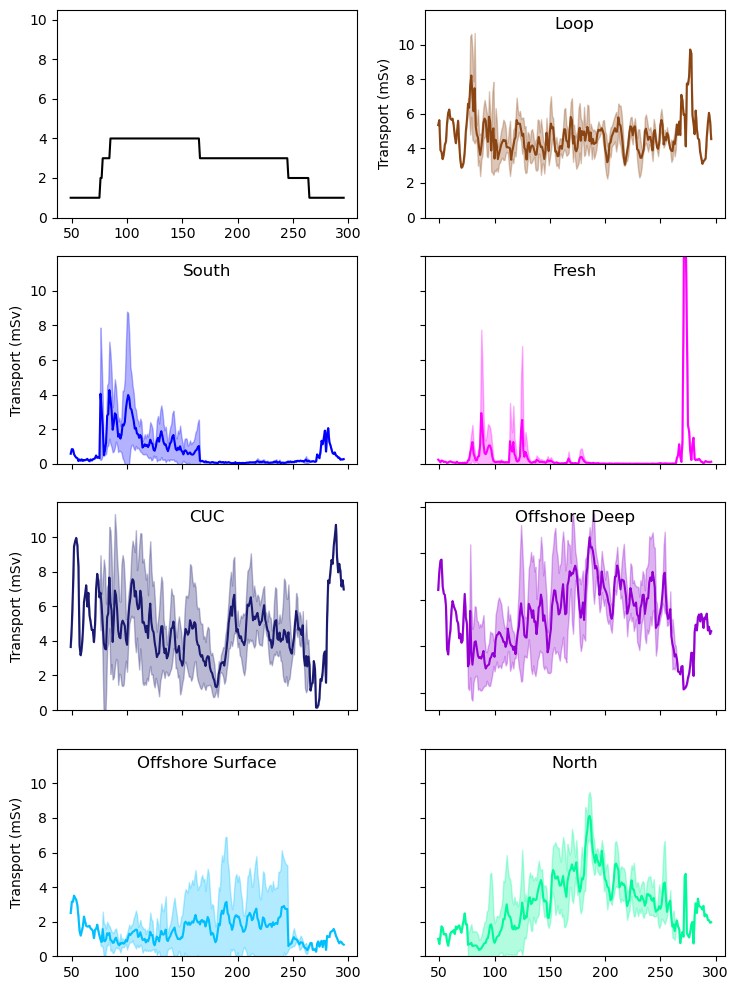

In [20]:
# using standard deviation

ymax=120000

fig, ax = plt.subplots(4,2, figsize=(7.5,10))

for axs in [ax[0,1],ax[1,0],ax[2,0],ax[3,0]]:
    axs.set_yticks([0,20000,40000,60000,80000,100000])
    axs.set_yticklabels(['0','2','4','6','8','10'])
    axs.set_ylabel('Transport (mSv)')

# count of the number of summers with this date in the range
ax[0,0].plot(loop.yearday,loop['count'],'k')
ax[0,0].set_ylim([0,10.5])

# loop flow
data = [loop.transport_2013,loop.transport_2014,loop.transport_2021,loop.transport_2022]
ax[0,1].plot(loop.yearday,np.nanmean(data,axis=0),'saddlebrown')
ax[0,1].fill_between(loop.yearday,
                        np.nanmean(data,axis=0)+np.nanstd(data,axis=0),
                        np.nanmean(data,axis=0)-np.nanstd(data,axis=0),
                        color='saddlebrown',alpha=0.3)
ax[0,1].set_xticklabels([])
ax[0,1].set_ylim([0,ymax])
ax[0,1].set_title('Loop',y=1,pad=-14)

# south shelf flow
# ax[1,0].plot(dates,mean_south)
data = [south.transport_2013,south.transport_2014,south.transport_2021,south.transport_2022]
ax[1,0].plot(south.yearday,np.nanmean(data,axis=0),'b')
ax[1,0].fill_between(south.yearday,
                        np.nanmean(data,axis=0)+np.nanstd(data,axis=0),
                        np.nanmean(data,axis=0)-np.nanstd(data,axis=0),
                        color='b',alpha=0.3)
ax[1,0].set_xticklabels([])
ax[1,0].set_ylim([0,ymax])
ax[1,0].set_title('South',y=1,pad=-14)


# fresh flow
# ax[1,1].plot(dates,mean_fresh)
data = [fresh.transport_2013,fresh.transport_2014, fresh.transport_2021,fresh.transport_2022]
ax[1,1].plot(fresh.yearday,np.nanmean(data,axis=0),'magenta')
ax[1,1].fill_between(fresh.yearday,
                        np.nanmean(data,axis=0)+np.nanstd(data,axis=0),
                        np.nanmean(data,axis=0)-np.nanstd(data,axis=0),
                        color='magenta',alpha=0.3)
ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])
ax[1,1].set_ylim([0,ymax])
ax[1,1].set_title('Fresh',y=1,pad=-14)

# cuc flow
data = [cuc.transport_2013,cuc.transport_2014,cuc.transport_2021,cuc.transport_2022]
ax[2,0].plot(cuc.yearday,np.nanmean(data,axis=0),'midnightblue')
ax[2,0].fill_between(cuc.yearday,
                        np.nanmean(data,axis=0)+np.nanstd(data,axis=0),
                        np.nanmean(data,axis=0)-np.nanstd(data,axis=0),
                        color='midnightblue',alpha=0.3)
ax[2,0].set_xticklabels([])
ax[2,0].set_ylim([0,ymax])
ax[2,0].set_title('CUC',y=1,pad=-14)

# offshore deep flow
data = [offshore_d.transport_2013,offshore_d.transport_2014,offshore_d.transport_2021,offshore_d.transport_2022]
ax[2,1].plot(offshore_d.yearday,np.nanmean(data,axis=0),'darkviolet')
ax[2,1].fill_between(offshore_d.yearday,
                        np.nanmean(data,axis=0)+np.nanstd(data,axis=0),
                        np.nanmean(data,axis=0)-np.nanstd(data,axis=0),
                        color='darkviolet',alpha=0.3)
ax[2,1].set_title('Offshore Deep',y=1,pad=-14)
ax[2,1].set_yticklabels([])
ax[2,1].set_xticklabels([])



# offshore surface flow
data = [offshore_s.transport_2013,offshore_d.transport_2014,offshore_s.transport_2021,offshore_s.transport_2022]
ax[3,0].plot(offshore_s.yearday,np.nanmean(data,axis=0),'deepskyblue')
ax[3,0].fill_between(offshore_s.yearday,
                        np.nanmean(data,axis=0)+np.nanstd(data,axis=0),
                        np.nanmean(data,axis=0)-np.nanstd(data,axis=0),
                        color='deepskyblue',alpha=0.3)
# ax[3,0].set_xticklabels([])
ax[3,0].set_ylim([0,ymax])
ax[3,0].set_title('Offshore Surface',y=1,pad=-14)


# north flow
data = [north.transport_2013,north.transport_2014,north.transport_2021,north.transport_2022]
ax[3,1].plot(north.yearday,np.nanmean(data,axis=0),'mediumspringgreen')
ax[3,1].fill_between(north.yearday,
                        np.nanmean(data,axis=0)+np.nanstd(data,axis=0),
                        np.nanmean(data,axis=0)-np.nanstd(data,axis=0),
                        color='mediumspringgreen',alpha=0.3)
# ax[3,1].set_xticklabels([])
ax[3,1].set_ylim([0,ymax])
ax[3,1].set_title('North',y=1,pad=-14)
ax[3,1].set_yticklabels([])


plt.tight_layout()

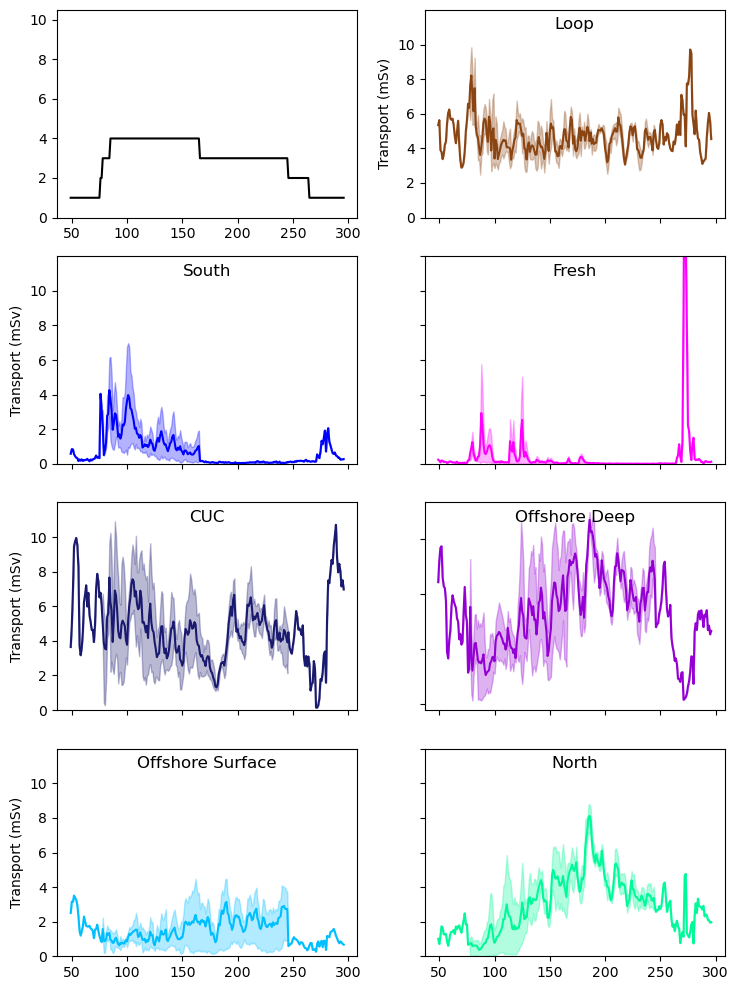

In [ ]:
# using quantile

ymax=120000

fig, ax = plt.subplots(4,2, figsize=(7.5,10))

for axs in [ax[0,1],ax[1,0],ax[2,0],ax[3,0]]:
    axs.set_yticks([0,20000,40000,60000,80000,100000])
    axs.set_yticklabels(['0','2','4','6','8','10'])
    axs.set_ylabel('Transport (mSv)')

# count of the number of summers with this date in the range
ax[0,0].plot(loop.yearday,loop['count'],'k')
ax[0,0].set_ylim([0,10.5])

# loop flow
data = [loop.transport_2013,loop.transport_2014,loop.transport_2021,loop.transport_2022]
ax[0,1].plot(loop.yearday,np.nanmean(data,axis=0),'saddlebrown')
ax[0,1].fill_between(loop.yearday,
                        np.nanpercentile(data, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(data, [75], method='midpoint',axis=0)[0],
                        color='saddlebrown',alpha=0.3)
ax[0,1].set_xticklabels([])
ax[0,1].set_ylim([0,ymax])
ax[0,1].set_title('Loop',y=1,pad=-14)

# south shelf flow
# ax[1,0].plot(dates,mean_south)
data = [south.transport_2013,south.transport_2014,south.transport_2021,south.transport_2022]
ax[1,0].plot(south.yearday,np.nanmean(data,axis=0),'b')
ax[1,0].fill_between(south.yearday,
                        np.nanpercentile(data, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(data, [75], method='midpoint',axis=0)[0],
                        color='b',alpha=0.3)
ax[1,0].set_xticklabels([])
ax[1,0].set_ylim([0,ymax])
ax[1,0].set_title('South',y=1,pad=-14)


# fresh flow
# ax[1,1].plot(dates,mean_fresh)
data = [fresh.transport_2013,fresh.transport_2014, fresh.transport_2021,fresh.transport_2022]
ax[1,1].plot(fresh.yearday,np.nanmean(data,axis=0),'magenta')
ax[1,1].fill_between(fresh.yearday,
                        np.nanpercentile(data, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(data, [75], method='midpoint',axis=0)[0],
                        color='magenta',alpha=0.3)
ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])
ax[1,1].set_ylim([0,ymax])
ax[1,1].set_title('Fresh',y=1,pad=-14)

# cuc flow
data = [cuc.transport_2013,cuc.transport_2014,cuc.transport_2021,cuc.transport_2022]
ax[2,0].plot(cuc.yearday,np.nanmean(data,axis=0),'midnightblue')
ax[2,0].fill_between(cuc.yearday,
                        np.nanpercentile(data, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(data, [75], method='midpoint',axis=0)[0],
                        color='midnightblue',alpha=0.3)
ax[2,0].set_xticklabels([])
ax[2,0].set_ylim([0,ymax])
ax[2,0].set_title('CUC',y=1,pad=-14)

# offshore deep flow
data = [offshore_d.transport_2013,offshore_d.transport_2014,offshore_d.transport_2021,offshore_d.transport_2022]
ax[2,1].plot(offshore_d.yearday,np.nanmean(data,axis=0),'darkviolet')
ax[2,1].fill_between(offshore_d.yearday,
                        np.nanpercentile(data, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(data, [75], method='midpoint',axis=0)[0],
                        color='darkviolet',alpha=0.3)
ax[2,1].set_title('Offshore Deep',y=1,pad=-14)
ax[2,1].set_yticklabels([])
ax[2,1].set_xticklabels([])



# offshore surface flow
data = [offshore_s.transport_2013,offshore_d.transport_2014,offshore_s.transport_2021,offshore_s.transport_2022]
ax[3,0].plot(offshore_s.yearday,np.nanmean(data,axis=0),'deepskyblue')
ax[3,0].fill_between(offshore_s.yearday,
                        np.nanpercentile(data, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(data, [75], method='midpoint',axis=0)[0],
                        color='deepskyblue',alpha=0.3)
# ax[3,0].set_xticklabels([])
ax[3,0].set_ylim([0,ymax])
ax[3,0].set_title('Offshore Surface',y=1,pad=-14)


# north flow
data = [north.transport_2013,north.transport_2014,north.transport_2021,north.transport_2022]
ax[3,1].plot(north.yearday,np.nanmean(data,axis=0),'mediumspringgreen')
ax[3,1].fill_between(north.yearday,
                        np.nanpercentile(data, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(data, [75], method='midpoint',axis=0)[0],
                        color='mediumspringgreen',alpha=0.3)
# ax[3,1].set_xticklabels([])
ax[3,1].set_ylim([0,ymax])
ax[3,1].set_title('North',y=1,pad=-14)
ax[3,1].set_yticklabels([])


plt.tight_layout()

## Downwelling

In [25]:
df21 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20220125/ariane_positions_quantitative.nc')
df20 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20210202/ariane_positions_quantitative.nc')
df13 = xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20140306/ariane_positions_quantitative.nc')


In [26]:
fresh21, cuc21, south21, north21, offshore_d21, offshore_s21, loop21 = wm_day_divide(df21)
fresh20, cuc20, south20, north20, offshore_d20, offshore_s20, loop20 = wm_day_divide(df20)
fresh13, cuc13, south13, north13, offshore_d13, offshore_s13, loop13 = wm_day_divide(df13)

In [27]:
endday = [dt.datetime(2014, 3, 6), dt.datetime(2021, 2, 2), dt.datetime(2022, 1, 25)] 
length = [113, 82, 105]  # Number of days in the season for each year
startday = [endday[i]-dt.timedelta(days=length[i]) for i in range(len(endday))]  # Start dates

In [28]:
fresh = transport_df([fresh13, fresh20,fresh21], startday, length,[2013, 2020,2021])
south = transport_df([south13, south20,south21], startday, length,[2013, 2020,2021])
north = transport_df([south13, north20,north21], startday, length,[2013, 2020,2021])
cuc = transport_df([cuc13,cuc20,cuc21, ], startday, length,[2013, 2020,2021])
offshore_d = transport_df([offshore_d13, offshore_d20,offshore_d21], startday, length,[2013, 2020,2021])
offshore_s = transport_df([offshore_s13, offshore_s20,offshore_s21], startday, length,[2013, 2020,2021])
loop = transport_df([loop13,loop20,loop21], startday, length,[2013, 2020,2021])

In [29]:
# number of similations overallaping in a julianne day
# can't do it the same way as in upwelling bc downwelling too erratic 
jsta = [date.timetuple().tm_yday for date in startday]
jend =[date.timetuple().tm_yday + 365 for date in endday]

counts = np.zeros(np.max(jend)-np.min(jsta)+1)
jul = (np.arange(np.min(jsta),np.max(jend)+1))

for i in range(len(counts)):
    for j in range(len(jsta)):
        if jul[i] >= jsta[j] and jul[i] <= jend[j]:
            counts[i]+=1


In [30]:
fresh.sort_values(by="yearday")
south.sort_values(by="yearday")
north.sort_values(by="yearday")
cuc.sort_values(by="yearday")
offshore_d.sort_values(by="yearday")
offshore_s.sort_values(by="yearday")
loop.sort_values(by="yearday")

# because its winter you need to add 365 to the dates January 1 onwards
fresh.loc[fresh.yearday<200,'yearday'] += 365
south.loc[south.yearday<200,'yearday'] += 365
north.loc[north.yearday<200,'yearday'] += 365
cuc.loc[cuc.yearday<200,'yearday'] += 365
offshore_d.loc[offshore_d.yearday<200,'yearday'] += 365
offshore_s.loc[offshore_s.yearday<200,'yearday'] += 365
loop.loc[loop.yearday<200,'yearday'] += 365

# and reorder
fresh.sort_values(by="yearday",inplace=True)
south.sort_values(by="yearday",inplace=True)
north.sort_values(by="yearday",inplace=True)
cuc.sort_values(by="yearday",inplace=True)
offshore_d.sort_values(by="yearday",inplace=True)
offshore_s.sort_values(by="yearday",inplace=True)
loop.sort_values(by="yearday",inplace=True)

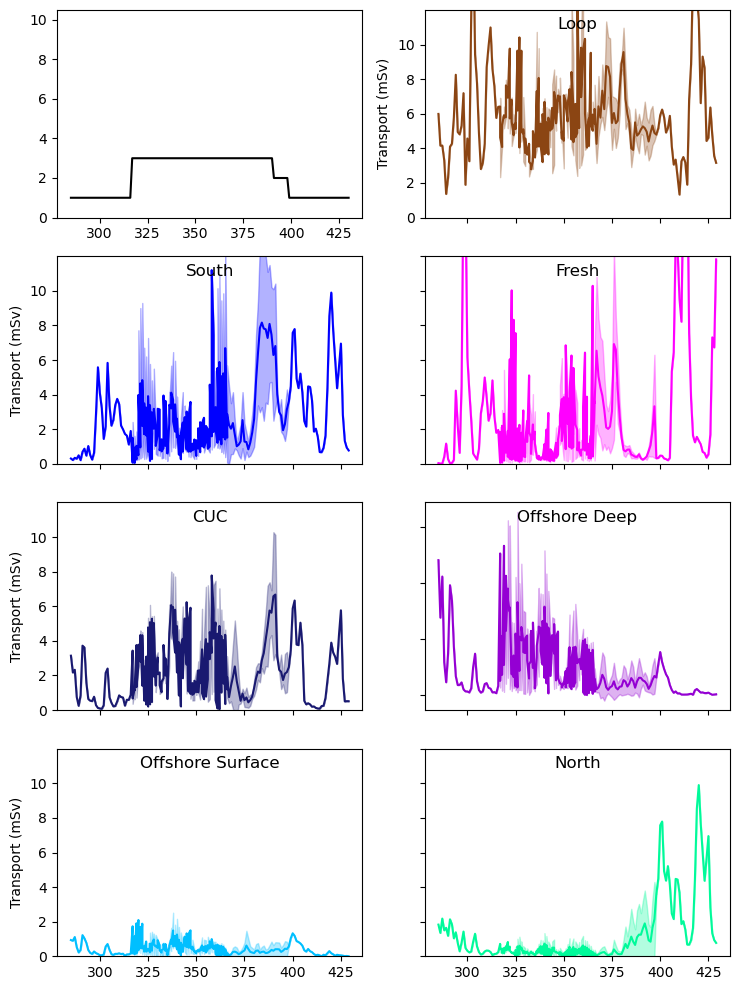

In [31]:
ymax=120000

fig, ax = plt.subplots(4,2, figsize=(7.5,10))

for axs in [ax[0,1],ax[1,0],ax[2,0],ax[3,0]]:
    axs.set_yticks([0,20000,40000,60000,80000,100000])
    axs.set_yticklabels(['0','2','4','6','8','10'])
    axs.set_ylabel('Transport (mSv)')

# count of the number of summers with this date in the range
ax[0,0].plot(jul,counts,'k')
ax[0,0].set_ylim([0,10.5])

# loop flow
data = [loop.transport_2013, loop.transport_2020,loop.transport_2021]
ax[0,1].plot(loop.yearday,np.nanmean(data,axis=0),'saddlebrown')
ax[0,1].fill_between(loop.yearday,
                        np.nanmean(data,axis=0)+np.nanstd(data,axis=0),
                        np.nanmean(data,axis=0)-np.nanstd(data,axis=0),
                        color='saddlebrown',alpha=0.3)
ax[0,1].set_xticklabels([])
ax[0,1].set_ylim([0,ymax])
ax[0,1].set_title('Loop',y=1,pad=-14)

# south shelf flow
# ax[1,0].plot(dates,mean_south)
data = [south.transport_2013, south.transport_2020,south.transport_2021]
ax[1,0].plot(south.yearday,np.nanmean(data,axis=0),'b')
ax[1,0].fill_between(south.yearday,
                        np.nanmean(data,axis=0)+np.nanstd(data,axis=0),
                        np.nanmean(data,axis=0)-np.nanstd(data,axis=0),
                        color='b',alpha=0.3)
ax[1,0].set_xticklabels([])
ax[1,0].set_ylim([0,ymax])
ax[1,0].set_title('South',y=1,pad=-14)


# fresh flow
# ax[1,1].plot(dates,mean_fresh)
data = [fresh.transport_2013, fresh.transport_2020,fresh.transport_2021]
ax[1,1].plot(fresh.yearday,np.nanmean(data,axis=0),'magenta')
ax[1,1].fill_between(fresh.yearday,
                        np.nanmean(data,axis=0)+np.nanstd(data,axis=0),
                        np.nanmean(data,axis=0)-np.nanstd(data,axis=0),
                        color='magenta',alpha=0.3)
ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])
ax[1,1].set_ylim([0,ymax])
ax[1,1].set_title('Fresh',y=1,pad=-14)

# cuc flow
data = [cuc.transport_2013, cuc.transport_2020,cuc.transport_2021]
ax[2,0].plot(cuc.yearday,np.nanmean(data,axis=0),'midnightblue')
ax[2,0].fill_between(cuc.yearday,
                        np.nanmean(data,axis=0)+np.nanstd(data,axis=0),
                        np.nanmean(data,axis=0)-np.nanstd(data,axis=0),
                        color='midnightblue',alpha=0.3)
ax[2,0].set_xticklabels([])
ax[2,0].set_ylim([0,ymax])
ax[2,0].set_title('CUC',y=1,pad=-14)

# offshore deep flow
data = [offshore_d.transport_2013, offshore_d.transport_2020,offshore_d.transport_2021]
ax[2,1].plot(offshore_d.yearday,np.nanmean(data,axis=0),'darkviolet')
ax[2,1].fill_between(offshore_d.yearday,
                        np.nanmean(data,axis=0)+np.nanstd(data,axis=0),
                        np.nanmean(data,axis=0)-np.nanstd(data,axis=0),
                        color='darkviolet',alpha=0.3)
ax[2,1].set_title('Offshore Deep',y=1,pad=-14)
ax[2,1].set_yticklabels([])
ax[2,1].set_xticklabels([])



# offshore surface flow
data = [offshore_s.transport_2013, offshore_s.transport_2020,offshore_s.transport_2021]
ax[3,0].plot(offshore_s.yearday,np.nanmean(data,axis=0),'deepskyblue')
ax[3,0].fill_between(offshore_s.yearday,
                        np.nanmean(data,axis=0)+np.nanstd(data,axis=0),
                        np.nanmean(data,axis=0)-np.nanstd(data,axis=0),
                        color='deepskyblue',alpha=0.3)
# ax[3,0].set_xticklabels([])
ax[3,0].set_ylim([0,ymax])
ax[3,0].set_title('Offshore Surface',y=1,pad=-14)


# north flow
data = [north.transport_2013, north.transport_2020,north.transport_2021]
ax[3,1].plot(north.yearday,np.nanmean(data,axis=0),'mediumspringgreen')
ax[3,1].fill_between(north.yearday,
                        np.nanmean(data,axis=0)+np.nanstd(data,axis=0),
                        np.nanmean(data,axis=0)-np.nanstd(data,axis=0),
                        color='mediumspringgreen',alpha=0.3)
# ax[3,1].set_xticklabels([])
ax[3,1].set_ylim([0,ymax])
ax[3,1].set_title('North',y=1,pad=-14)
ax[3,1].set_yticklabels([])


plt.tight_layout()

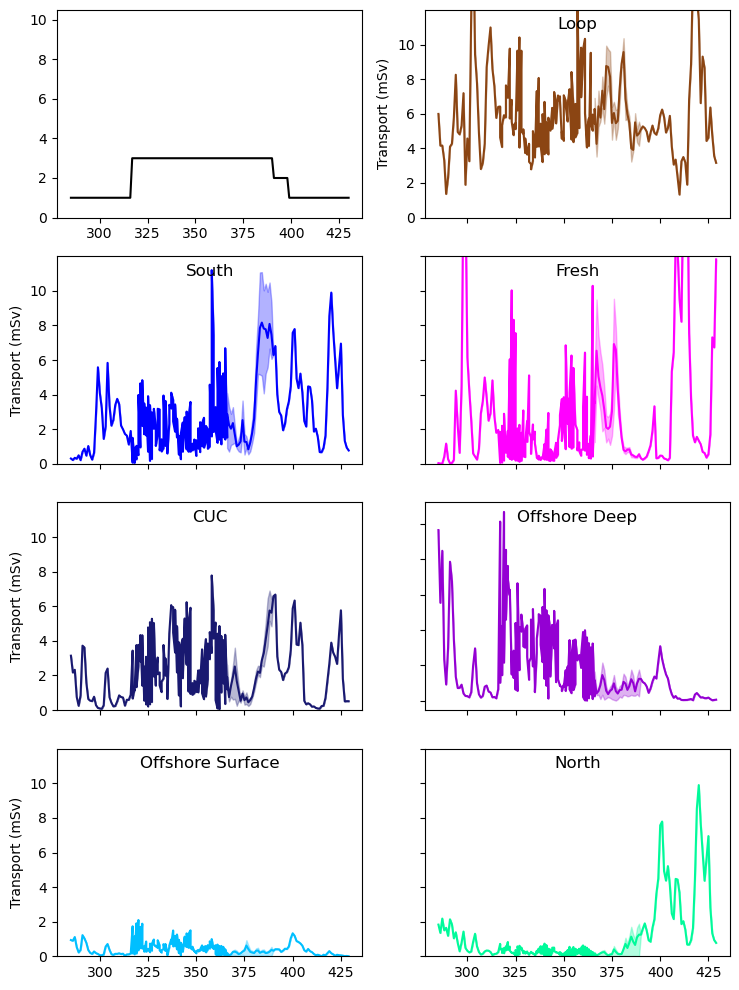

In [32]:
# using quantiles
ymax=120000

fig, ax = plt.subplots(4,2, figsize=(7.5,10))

for axs in [ax[0,1],ax[1,0],ax[2,0],ax[3,0]]:
    axs.set_yticks([0,20000,40000,60000,80000,100000])
    axs.set_yticklabels(['0','2','4','6','8','10'])
    axs.set_ylabel('Transport (mSv)')

# count of the number of summers with this date in the range
ax[0,0].plot(jul,counts,'k')
ax[0,0].set_ylim([0,10.5])

# loop flow
data = [loop.transport_2013, loop.transport_2020,loop.transport_2021]
ax[0,1].plot(loop.yearday,np.nanmean(data,axis=0),'saddlebrown')
ax[0,1].fill_between(loop.yearday,
                        np.nanpercentile(data, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(data, [75], method='midpoint',axis=0)[0],
                        color='saddlebrown',alpha=0.3)
ax[0,1].set_xticklabels([])
ax[0,1].set_ylim([0,ymax])
ax[0,1].set_title('Loop',y=1,pad=-14)

# south shelf flow
# ax[1,0].plot(dates,mean_south)
data = [south.transport_2013, south.transport_2020,south.transport_2021]
ax[1,0].plot(south.yearday,np.nanmean(data,axis=0),'b')
ax[1,0].fill_between(south.yearday,
                        np.nanpercentile(data, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(data, [75], method='midpoint',axis=0)[0],
                        color='b',alpha=0.3)
ax[1,0].set_xticklabels([])
ax[1,0].set_ylim([0,ymax])
ax[1,0].set_title('South',y=1,pad=-14)


# fresh flow
# ax[1,1].plot(dates,mean_fresh)
data = [fresh.transport_2013, fresh.transport_2020,fresh.transport_2021]
ax[1,1].plot(fresh.yearday,np.nanmean(data,axis=0),'magenta')
ax[1,1].fill_between(fresh.yearday,
                        np.nanpercentile(data, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(data, [75], method='midpoint',axis=0)[0],
                        color='magenta',alpha=0.3)
ax[1,1].set_yticklabels([])
ax[1,1].set_xticklabels([])
ax[1,1].set_ylim([0,ymax])
ax[1,1].set_title('Fresh',y=1,pad=-14)

# cuc flow
data = [cuc.transport_2013, cuc.transport_2020,cuc.transport_2021]
ax[2,0].plot(cuc.yearday,np.nanmean(data,axis=0),'midnightblue')
ax[2,0].fill_between(cuc.yearday,
                        np.nanpercentile(data, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(data, [75], method='midpoint',axis=0)[0],
                        color='midnightblue',alpha=0.3)
ax[2,0].set_xticklabels([])
ax[2,0].set_ylim([0,ymax])
ax[2,0].set_title('CUC',y=1,pad=-14)

# offshore deep flow
data = [offshore_d.transport_2013, offshore_d.transport_2020,offshore_d.transport_2021]
ax[2,1].plot(offshore_d.yearday,np.nanmean(data,axis=0),'darkviolet')
ax[2,1].fill_between(offshore_d.yearday,
                        np.nanpercentile(data, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(data, [75], method='midpoint',axis=0)[0],
                        color='darkviolet',alpha=0.3)
ax[2,1].set_title('Offshore Deep',y=1,pad=-14)
ax[2,1].set_yticklabels([])
ax[2,1].set_xticklabels([])



# offshore surface flow
data = [offshore_s.transport_2013, offshore_s.transport_2020,offshore_s.transport_2021]
ax[3,0].plot(offshore_s.yearday,np.nanmean(data,axis=0),'deepskyblue')
ax[3,0].fill_between(offshore_s.yearday,
                        np.nanpercentile(data, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(data, [75], method='midpoint',axis=0)[0],
                        color='deepskyblue',alpha=0.3)
# ax[3,0].set_xticklabels([])
ax[3,0].set_ylim([0,ymax])
ax[3,0].set_title('Offshore Surface',y=1,pad=-14)


# north flow
data = [north.transport_2013, north.transport_2020,north.transport_2021]
ax[3,1].plot(north.yearday,np.nanmean(data,axis=0),'mediumspringgreen')
ax[3,1].fill_between(north.yearday,
                        np.nanpercentile(data, [25], method='midpoint',axis=0)[0],
                        np.nanpercentile(data, [75], method='midpoint',axis=0)[0],
                        color='mediumspringgreen',alpha=0.3)
# ax[3,1].set_xticklabels([])
ax[3,1].set_ylim([0,ymax])
ax[3,1].set_title('North',y=1,pad=-14)
ax[3,1].set_yticklabels([])


plt.tight_layout()